In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# MagAO-X function definitions
import magaoxFunctions as mf
# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy
import PSD_defns as psd
from scipy import interpolate

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
print('This notebook is not stale yet!')

This notebook is not stale yet!


In [3]:
# filter the OAP data
ca_new = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 50.8*u.mm
k_ll = 1/(D_full_1 * ca_new / 100)

# declare the optics
kval_1 = {}
mn_psd_1 = {}
mc_psd_1 = {}
npix_diam_1 = {}
var_1 = {}
surf_pwr_1 = {}
delta_k_1 = {}
n_oap_list = []

for ntest in range(0,ntot_1):
    # set file name
    if ntest < 5: # OAP5 has 3 versions
        data_loc = 'zygo_data/oaps/OAP{}_Pre-Coat.fits'.format(ntest)
        new_loc = 'zygo_data/oaps/OAP{}_Pre-Coat_sqr.fits'.format(ntest)
        mask_loc = 'zygo_data/oaps/OAP{}_Pre-Coat_mask.fits'.format(ntest)
        n_oap = 'n{}'.format(ntest)
    else:
        snum = (ntest - 5) + 1 # serial number
        data_loc = 'zygo_data/oaps/OAP5_SN0{}_Pre-Coat.fits'.format(snum)
        new_loc = 'zygo_data/oaps/OAP5_SN0{}_Pre-Coat_sqr.fits'.format(snum)
        mask_loc = 'zygo_data/oaps/OAP5_SN0{}_Pre-Coat_mask.fits'.format(snum)
        n_oap = 'n5_sn{}'.format(snum)
    n_oap_list.append(n_oap)
    
    # clean up the raw data, save to new fits file
    raw_data, raw_header = fits.getdata(data_loc, header=True)
    optic_data, mask_data = psd.filter_Zygo(raw_data)
    fits.writeto(new_loc, optic_data, overwrite=True)
    fits.writeto(mask_loc, mask_data, overwrite=True)
    
    # need to make a loop to eliminate ntest=2 because there's bad data in there.
    if ntest != 2: 
        # pass in the data for generating PSD content
        # open the optic surface
        surf_data = optic_data * u.um * u.mm / (1e3*u.um) # convert original um data to mm
        print('surf unit at n{}: {}'.format(ntest, surf_data.unit))

        # calculate the power optic data
        (pwr_opt, npix_diam, ap_var) = psd.calc_surfPower(surf_data, D_full_1, ca_new, oversamp_size)

        # convert ap_var from mm^2 to nm^2
        ap_var *= 1e6*(u.nm/u.mm) * 1e6*(u.nm/u.mm) # convert variance mm2 to nm2
        print('var at n{}: {:.3f}'.format(ntest, ap_var))

        # calculate the spatial frequency content
        (delta_k, FT_freq) = psd.calc_spatialFreq(oversamp_size, npix_diam, ca_new, D_full_1)
        print('delta k at n{}: {:.5f}'.format(ntest, delta_k))

        norm_psd = psd.calc_normPSD(pwr_opt, delta_k)
        print('var test n{}: {:.3f}'.format(ntest, np.sum(norm_psd) * (delta_k**2)))
        cal_psd = norm_psd * ap_var # there is function calc_calPSD but that's for a different time
        print('cal var test n{}: {:.3f}'.format(ntest, np.sum(cal_psd) * (delta_k**2)))

        # calculate the PSD data from the variance-normalized PSD
        #(kval, mean_val) = psd.calc_radialPSD(norm_psd, FT_freq, dr_width)
        (kval, mv_n, mv_c) = psd.calc_radialPSD2(norm_psd, cal_psd, FT_freq, dr_width, k_ll.value)
        print('norm PSD units n{}: {}'.format(ntest, mv_n.unit)) # should be mm2
        print('cal PSD units n{}: {}'.format(ntest, mv_c.unit))  # should be mm2 nm2

        print('Finished calculating PSD for surface {}'.format(ntest))
    
    else: # only occurs at n=2 where there is bad data
        print('At surface {}, will skip PSD generation due to bad data. All contents are zero.'.format(n_oap))
        kval = 0
        mean_val = 0
        npix_diam = 0
        ap_var = 0
    
    # fill in the parameter space, units come through
    kval_1[n_oap] = copy.copy(kval)
    mn_psd_1[n_oap] = copy.copy(mv_n)
    mc_psd_1[n_oap] = copy.copy(mv_c)
    npix_diam_1[n_oap] = copy.copy(npix_diam)
    var_1[n_oap] = copy.copy(ap_var)
    surf_pwr_1[n_oap] = copy.copy(pwr_opt)
    delta_k_1[n_oap] = copy.copy(delta_k)

print('All PSD measurement tests done.')

surf unit at n0: mm
var at n0: 19.453 nm2
delta k at n0: 0.00148 1 / mm
PSD normalized: var=1.000
var test n0: 1.000
cal var test n0: 19.453 nm2
norm PSD units n0: mm2
cal PSD units n0: mm2 nm2
Finished calculating PSD for surface 0
surf unit at n1: mm
var at n1: 12.838 nm2
delta k at n1: 0.00149 1 / mm
PSD normalized: var=1.000
var test n1: 1.000
cal var test n1: 12.838 nm2
norm PSD units n1: mm2
cal PSD units n1: mm2 nm2
Finished calculating PSD for surface 1
At surface n2, will skip PSD generation due to bad data. All contents are zero.
surf unit at n3: mm
var at n3: 9.581 nm2
delta k at n3: 0.00125 1 / mm
PSD normalized: var=1.000
var test n3: 1.000
cal var test n3: 9.581 nm2
norm PSD units n3: mm2
cal PSD units n3: mm2 nm2
Finished calculating PSD for surface 3
surf unit at n4: mm
var at n4: 10.387 nm2
delta k at n4: 0.00125 1 / mm
PSD normalized: var=1.000
var test n4: 1.000
cal var test n4: 10.387 nm2
norm PSD units n4: mm2
cal PSD units n4: mm2 nm2
Finished calculating PSD for 

In [4]:
for no in range(0,ntot_1):
    if no != 2:
        print('delta_k at {}: {:.5f}'.format(n_oap_list[no], delta_k_1[n_oap_list[no]]))

delta_k at n0: 0.00148 1 / mm
delta_k at n1: 0.00149 1 / mm
delta_k at n3: 0.00125 1 / mm
delta_k at n4: 0.00125 1 / mm
delta_k at n5_sn1: 0.00126 1 / mm
delta_k at n5_sn2: 0.00126 1 / mm
delta_k at n5_sn3: 0.00126 1 / mm


In [42]:
kmin = []
kmax = []
var_data = []
npix_diam = []
for no in range(0,ntot_1):
    if no != 2:
        name = n_oap_list[no]
        kmax.append(np.amax(kval_1[name]).value)
        kmin.append(np.amin(kval_1[name]).value)
        var_data.append(var_1[name].value)
        npix_diam.append(npix_diam_1[name])
#         print('k min at {}: {:.5f}'.format(n_oap_list[no], np.amin(kval_1[n_oap_list[no]])))
#         print('k max at {}: {:.5f}'.format(n_oap_list[no], np.amax(kval_1[n_oap_list[no]])))
#         print('---')
var_data *= var_1[name].unit
kmin_interp = np.amax(kmin)*kval_1[name].unit
kmax_interp = np.amin(kmax)*kval_1[name].unit
avg_tot_var = np.mean(var_data)
avg_npix_diam = np.mean(npix_diam)
print('average var = {:.3f}'.format(avg_tot_var))
print('maximum kmin = {:.3f}'.format(kmin_interp))
print('minimum kmax = {:.3f}'.format(kmax_interp))

average var = 17.300 nm2
maximum kmin = 0.025 1 / mm
minimum kmax = 2.555 1 / mm


In [11]:
np.sqrt(var_data)

<Quantity [4.4105092 , 3.58305701, 3.09532956, 3.22282867, 5.34092867,
           4.60930637, 4.36733071] nm>

In [12]:
k_ll

<Quantity 0.0246063 1 / mm>

In [13]:
d = {}
nyq_lim = {}
for no in range(0,ntot_1):
    if no != 2:
        name = n_oap_list[no]
        d[name] = (D_full_1 * ca_new / 100) / npix_diam_1[name]
        nyq_lim[name] = 1 / (2 * d[name])
        print('nyquist limit at {}: {}'.format(name, nyq_lim[name]))

nyquist limit at n0: 3.0265748031496065 1 / mm
nyquist limit at n1: 3.0511811023622046 1 / mm
nyquist limit at n3: 2.559055118110236 1 / mm
nyquist limit at n4: 2.559055118110236 1 / mm
nyquist limit at n5_sn1: 2.5836614173228347 1 / mm
nyquist limit at n5_sn2: 2.5836614173228347 1 / mm
nyquist limit at n5_sn3: 2.5836614173228347 1 / mm


In [25]:
# interpolation of the data
k_npts = 450 # number of spatial frequency sample points
k_new = np.linspace(kmin_interp, kmax_interp, num=k_npts) # new range of spatial frequencies
new_psd_data = np.zeros((ntot_1, k_npts)) # all k_val is same size
new_psd_norm = np.zeros((ntot_1, k_npts)) # all k_val is same size

# original psd data
k_orig = np.zeros((ntot_1, np.shape(kval_1[n_oap_list[0]])[0]))
psd_data = np.zeros((ntot_1, np.shape(kval_1[n_oap_list[0]])[0]))
psd_norm = np.zeros((ntot_1, np.shape(kval_1[n_oap_list[0]])[0]))

# fill in the data matricies from the PSD simulation and interpolate
for no in range(0,ntot_1):
    if no != 2:
        # fill in the data
        name = n_oap_list[no]
        k_orig[no,:] = kval_1[name]
        psd_data[no,:] = mc_psd_1[name]
        psd_norm[no,:] = mn_psd_1[name]
        
        # calculate the interpolation
        f_data = interpolate.interp1d(k_orig[no,:], psd_data[no,:])
        f_norm = interpolate.interp1d(k_orig[no,:], psd_norm[no,:])
        
        # fill in the interpolation
        new_psd_data[no,:] = f_data(k_new)
        new_psd_norm[no,:] = f_norm(k_new)

# apply the units
new_psd_data *= mc_psd_1[name].unit
new_psd_norm *= mn_psd_1[name].unit

In [27]:
k_new

<Quantity [0.02532719, 0.03096188, 0.03659658, 0.04223128, 0.04786598,
           0.05350068, 0.05913537, 0.06477007, 0.07040477, 0.07603947,
           0.08167416, 0.08730886, 0.09294356, 0.09857826, 0.10421296,
           0.10984765, 0.11548235, 0.12111705, 0.12675175, 0.13238645,
           0.13802114, 0.14365584, 0.14929054, 0.15492524, 0.16055993,
           0.16619463, 0.17182933, 0.17746403, 0.18309873, 0.18873342,
           0.19436812, 0.20000282, 0.20563752, 0.21127221, 0.21690691,
           0.22254161, 0.22817631, 0.23381101, 0.2394457 , 0.2450804 ,
           0.2507151 , 0.2563498 , 0.26198449, 0.26761919, 0.27325389,
           0.27888859, 0.28452329, 0.29015798, 0.29579268, 0.30142738,
           0.30706208, 0.31269678, 0.31833147, 0.32396617, 0.32960087,
           0.33523557, 0.34087026, 0.34650496, 0.35213966, 0.35777436,
           0.36340906, 0.36904375, 0.37467845, 0.38031315, 0.38594785,
           0.39158254, 0.39721724, 0.40285194, 0.40848664, 0.41412134,
      

In [30]:
# calculate the average PSDs
# generate the average PSD

# step 1: Collect the individual surface variances and get the average
avg_tot_rms = np.sqrt(avg_tot_var)

# step 2: Make a collection of variance-normalized PSDs
# psd_norm

# Step 3: Take average of collection of variance-normalized PSDs and data calibrated PSDs
avg_psd = np.zeros((k_npts))
avg_psd_data = np.zeros((k_npts))
for i in range(0,k_npts):
    avg_psd[i] = np.sum(new_psd_norm[:,i].value)/(ntot_1-1) # subtract surface 2 for mean
    avg_psd_data[i] = np.sum(new_psd_data[:,i].value)/(ntot_1-1) # subtract surface 2 for mean

# Step 4: scale the average norm PSD by average variance data from Step 1
# also, apply units.
avg_psd_norm = avg_psd * new_psd_norm.unit * avg_tot_var
avg_psd_data *= new_psd_data.unit

# Step 5: Apply the average PSD shape with the radial profile
# The radial profile remains the same (kval_1) because all the data is on the same scales.

print('Finished calculating average PSDs (normalized and calibrated)')

Finished calculating average PSDs (normalized and calibrated)


Text(0, 0.5, 'Surface PSD (mm2 nm2)')

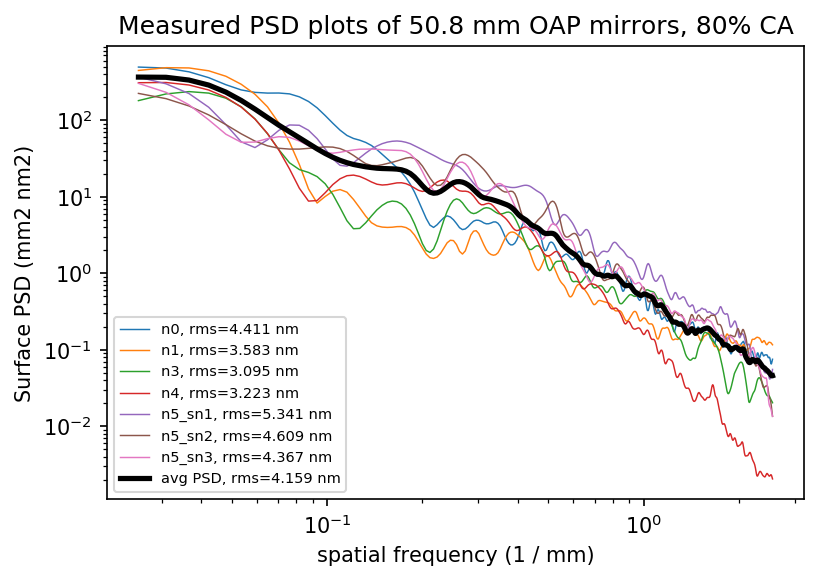

In [66]:
# This data is interpolated
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    if ns !=2:
        name = n_oap_list[ns]
        plt.loglog(k_new, new_psd_data[ns,:], label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=0.7)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='avg PSD, rms={:.3f}'.format(avg_tot_rms), linewidth=2.5)  
plt.title('Measured PSD plots of {} OAP mirrors, {}% CA'.format(D_full_1, ca_new))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2) [var=1.0]')

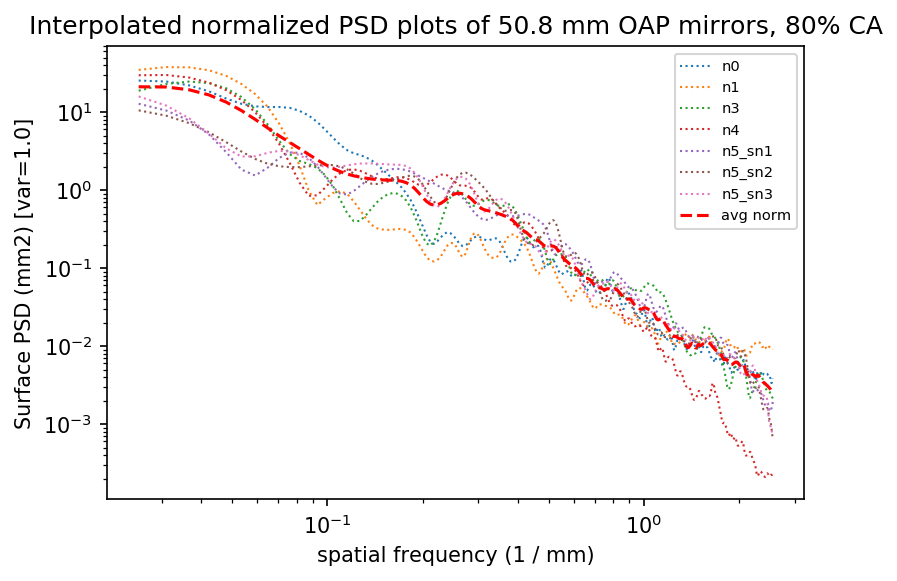

In [36]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    if ns !=2:
        name = n_oap_list[ns]
        plt.loglog(k_new, new_psd_norm[ns,:], ':', label='{}'.format(name), linewidth=1.0)
plt.loglog(k_new, avg_psd, 'r--', label='avg norm')  
plt.title('Interpolated normalized PSD plots of {} OAP mirrors, {}% CA'.format(D_full_1, ca_new))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({}) [var=1.0]'.format(new_psd_norm.unit)) 
#plt.style.use('classic')

## Modelling the PSD
Finding alpha, beta, l0, L0

In [37]:
def calc_beta(alpha, var, D_clear, npix_diam):
    kmin = 1 / D_clear
    kmax = 1/ (2 * D_clear / npix_diam)
    
    if alpha == 2:
        beta = var / ( 2* np.pi * np.log(kmax/kmin) )
    else: # when beta is not 2
        beta = var * (alpha - 2) / (2 * np.pi * ( (kmin**(2 - alpha)) - (kmax**(2 - alpha)) ) )
    
    return beta

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

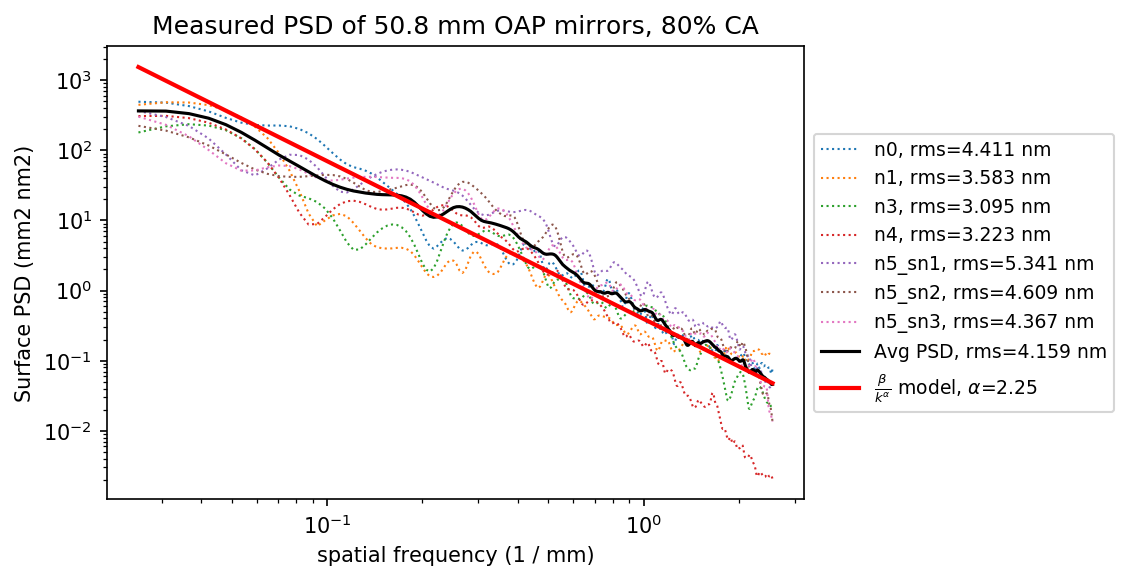

In [163]:
# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
#klim = 0.15
klim = np.amin(k_new.value)
kfit = np.zeros((k_npts))
for kn in range(0,k_npts):
    kfit[kn] = np.abs(k_new[kn].value - klim)
klim_ind = np.argmin(kfit)
k_range = k_new[klim_ind:k_npts]

a2 = 2.25 # estimate for OAP
b2 = calc_beta(a2, avg_tot_var, D_full_1*ca_new/100, avg_npix_diam)
a2_fit = b2/(k_range**a2)
a2_fit1 = b2/((avg_tot_var**a2)*(k_range**a2))

# plotting
plt.figure(dpi=150)
for ns in range(0,ntot_1):
   if ns !=2:
       name = n_oap_list[ns]
       plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.title('Measured PSD of {} OAP mirrors, {}% CA'.format(D_full_1, ca_new))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

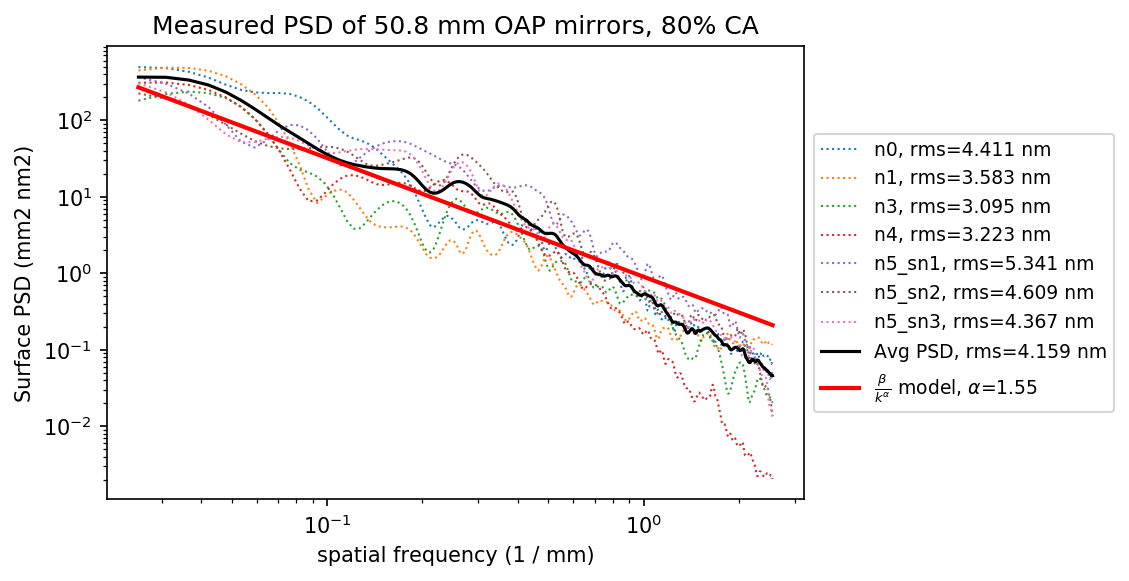

In [164]:
# alpha and beta should be fit on the mid-spatial frequency content region
# choose the cut-off for position
#klim = 0.15
klim = np.amin(k_new.value)
kfit = np.zeros((k_npts))
for kn in range(0,k_npts):
    kfit[kn] = np.abs(k_new[kn].value - klim)
klim_ind = np.argmin(kfit)
k_range = k_new[klim_ind:k_npts]

a2 = 1.55 # estimate for OAP
b2 = calc_beta(a2, avg_tot_var, D_full_1*ca_new/100, avg_npix_diam)
a2_fit = b2/(k_range**a2)
a2_fit1 = b2/((avg_tot_var**a2)*(k_range**a2))

# plotting
plt.figure(dpi=150)
for ns in range(0,ntot_1):
   if ns !=2:
       name = n_oap_list[ns]
       plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.title('Measured PSD of {} OAP mirrors, {}% CA'.format(D_full_1, ca_new))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

In [202]:
k_far = np.linspace(klim, 4.5, k_npts+100)

L0 = 15
lo = 0.7
psd_full = b2 * np.exp(-(k_far*lo)**2) / ( ( (L0**-2) + (k_far**2) ) ** (a2*.5))
psd_fit = (b2/(k_far**a2)) * np.exp(-(k_far * lo)**2)

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

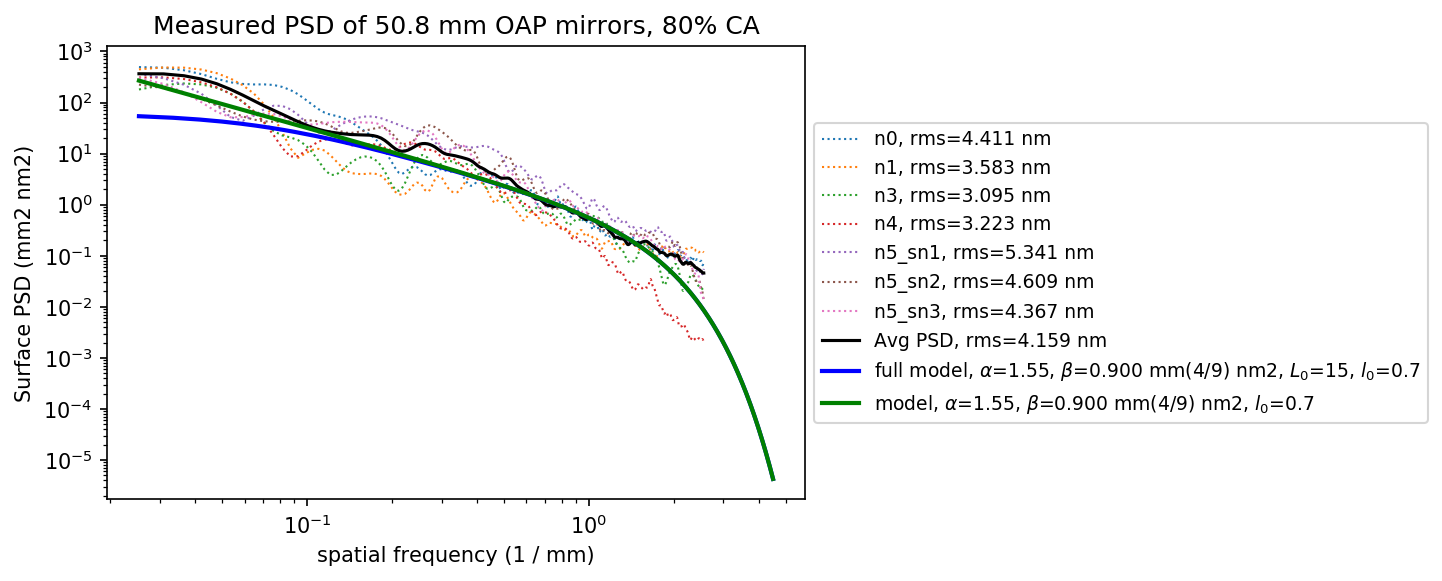

In [203]:
# plotting
plt.figure(dpi=150)
for ns in range(0,ntot_1):
   if ns !=2:
       name = n_oap_list[ns]
       plt.loglog(k_new, new_psd_data[ns,:], ':', label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])), linewidth=1.0)
#plt.loglog(k_new, avg_psd_data, 'k--', label='avg PSD data')
plt.loglog(k_new, avg_psd_norm, 'k', label='Avg PSD, rms={:.3f}'.format(avg_tot_rms)) 
#plt.loglog(k_new, alpha_fit, label='alpha={}'.format(alpha))
#plt.loglog(k_new, a2_fit, label='{} model fit'.format(r'$\frac{$\beta$}{k^{$\alpha$}}$'))
#plt.loglog(k_range, a2_fit, 'r', label='{} model, {}={}'.format(r'$\frac{\beta}{k^{\alpha}}$', r'$\alpha$',a2), linewidth=2.0)
#plt.loglog(k_range, a2_fit1, 'g', label='{} model fit'.format(r'$\frac{\beta}{(var_{avg} k)^{\alpha}}$', linewidth=2.0))
plt.loglog(k_far, psd_full, 'b', label='full model, {}={}, {}={:.3f}, {}={}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$L_{0}$',L0, r'$l_{0}$', lo), linewidth=2.0)
plt.loglog(k_far, psd_fit, 'g', label='model, {}={}, {}={:.3f}, {}={}'.format(r'$\alpha$',a2,r'$\beta$',b2, r'$l_{0}$', lo), linewidth=2.0)
plt.title('Measured PSD of {} OAP mirrors, {}% CA'.format(D_full_1, ca_new))
plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('spatial frequency ({})'.format(k_new.unit))
plt.ylabel('Surface PSD ({})'.format(new_psd_data.unit)) 

### Data exploration

In [256]:
# filter the OAP data
ca_new = 80
oversamp_size = 4096
dr_width = 5
ntot_1 = 8 # goes from 1-8
D_full_1 = 50.8*u.mm
k_ll = 1/(D_full_1 * ca_new / 100)

# declare the optics
surf_val = {}
mask_data = {}
n_oap_list = []
max_val = []
min_val = []

for ntest in range(0,ntot_1):
    # set file name
    if ntest < 5: # OAP5 has 3 versions
        data_loc = 'zygo_data/oaps/OAP{}_Pre-Coat.fits'.format(ntest)
        new_loc = 'zygo_data/oaps/OAP{}_Pre-Coat_sqr.fits'.format(ntest)
        mask_loc = 'zygo_data/oaps/OAP{}_Pre-Coat_mask.fits'.format(ntest)
        n_oap = 'n{}'.format(ntest)
    else:
        snum = (ntest - 5) + 1 # serial number
        data_loc = 'zygo_data/oaps/OAP5_SN0{}_Pre-Coat.fits'.format(snum)
        new_loc = 'zygo_data/oaps/OAP5_SN0{}_Pre-Coat_sqr.fits'.format(snum)
        mask_loc = 'zygo_data/oaps/OAP5_SN0{}_Pre-Coat_mask.fits'.format(snum)
        n_oap = 'n5_sn{}'.format(snum)
    n_oap_list.append(n_oap)
    
    # clean up the raw data, save to new fits file
    raw_data, raw_header = fits.getdata(data_loc, header=True)
    optic_data, mask = psd.filter_Zygo(raw_data)
    
    surf_data = optic_data * u.um * (1e3*u.nm/u.um) # convert original um data to mm
    
    max_val.append(np.amax(surf_data.value))
    min_val.append(np.amin(surf_data.value))
    
    # fill in the parameter space, units come through
    surf_val[n_oap] = copy.copy(surf_data)
    mask_data[n_oap] = copy.copy(mask)

tot_max = np.amax(max_val)
tot_min = np.amax(min_val)

In [212]:
surf_val['n0']

<Quantity [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]] nm>

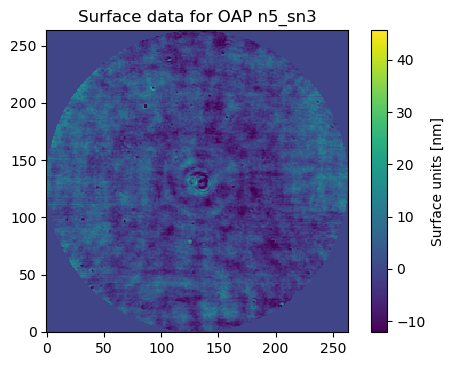

In [265]:
no = 7
name = n_oap_list[no]
msk = mask_data[name]
data = surf_val[name].value
plt.figure(dpi=100)
plt.imshow(msk*data, origin='lower', vmin=tot_min, vmax=tot_max)
plt.title('Surface data for OAP {}'.format(name))
plt.colorbar().set_label('Surface units [{}]'.format(surf_data.unit))

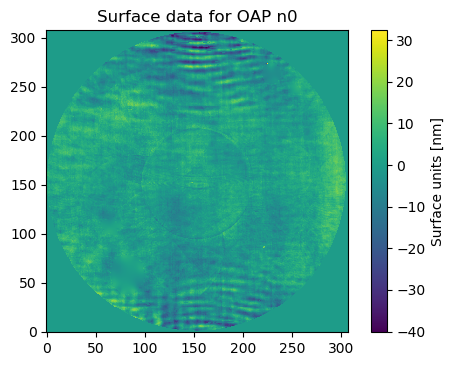

In [49]:
for no in range(0,ntot_1):
    if no != 2:
        print('shape at {}: {}'.format(n_oap_list[no], np.shape(surf_pwr_1[n_oap_list[no]])))

shape at n0: (4096, 4096)
shape at n1: (4096, 4096)
shape at n3: (4096, 4096)
shape at n4: (4096, 4096)
shape at n5_sn1: (4096, 4096)
shape at n5_sn2: (4096, 4096)
shape at n5_sn3: (4096, 4096)


In [29]:
for no in range(0,ntot_1):
    if no != 2:
        print('size of kval at {}: {}'.format(n_oap_list[no],np.shape(kval_1[n_oap_list[no]])))

size of kval at n0: (406,)
size of kval at n1: (406,)
size of kval at n3: (406,)
size of kval at n4: (406,)
size of kval at n5_sn1: (406,)
size of kval at n5_sn2: (406,)
size of kval at n5_sn3: (406,)


In [29]:
for no in range(0,ntot_1):
    if no != 2:
        print('size of kval at {}: {}'.format(n_oap_list[no],np.shape(kval_1[n_oap_list[no]])))

size of kval at n0: (406,)
size of kval at n1: (406,)
size of kval at n3: (406,)
size of kval at n4: (406,)
size of kval at n5_sn1: (406,)
size of kval at n5_sn2: (406,)
size of kval at n5_sn3: (406,)


Text(0, 0.5, 'spatial frequency number (1 / mm)')

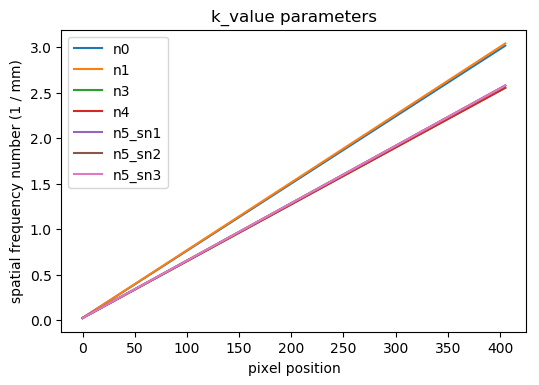

In [57]:
plt.figure(dpi=100)
for ns in range(0,ntot_1):
    if ns != 2:
        name=n_oap_list[ns]
        plt.plot(kval_1[name], label=name)
plt.legend()
plt.title('k_value parameters')
plt.xlabel('pixel position')
plt.ylabel('spatial frequency number ({})'.format(delta_k_val.unit))

In [20]:
npix_diam_1

{'n0': 246,
 'n1': 248,
 'n2': 0,
 'n3': 208,
 'n4': 208,
 'n5_sn1': 210,
 'n5_sn2': 210,
 'n5_sn3': 210}

In [60]:
var_1

{'n0': <Quantity 19.45259137 nm2>,
 'n1': <Quantity 12.83829751 nm2>,
 'n2': 0,
 'n3': <Quantity 9.58106511 nm2>,
 'n4': <Quantity 10.38662462 nm2>,
 'n5_sn1': <Quantity 28.52551903 nm2>,
 'n5_sn2': <Quantity 21.24570522 nm2>,
 'n5_sn3': <Quantity 19.0735775 nm2>}

Text(0, 0.5, 'Surface PSD (mm2 nm2)')

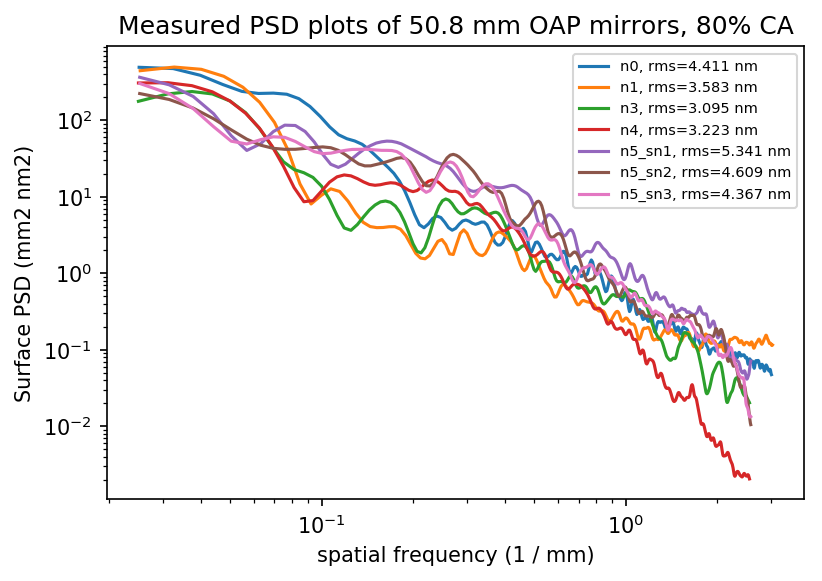

In [27]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    if ns !=2:
        name = n_oap_list[ns]
        plt.loglog(kval_1[name], mc_psd_1[name], label='{}, rms={:.3f}'.format(name, np.sqrt(var_1[name])))
plt.title('Measured PSD plots of {} OAP mirrors, {}% CA'.format(D_full_1, ca_80))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1[name].unit))
plt.ylabel('Surface PSD ({})'.format(mc_psd_1[name].unit)) 

Text(0, 0.5, 'Surface PSD (mm2) [var norm =1.0]')

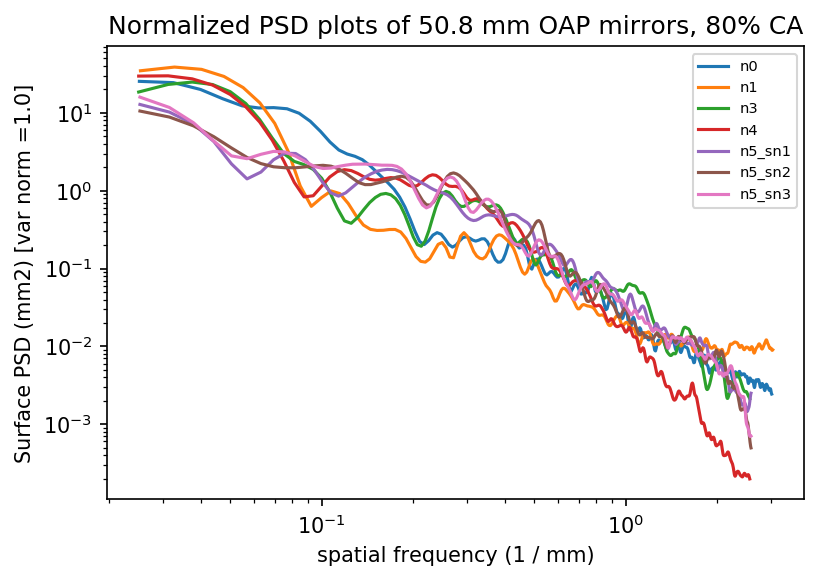

In [28]:
# convert mean from mm^2 mm^2 to nm^2 mm^2
#mean_val_nm2 = [i*1e12 for i in mean_psd_arr[0,:]]
rms_1 = np.sqrt
plt.figure(dpi=150)
for ns in range(0,ntot_1):
    if ns !=2:
        name = n_oap_list[ns]
        plt.loglog(kval_1[name], mn_psd_1[name], label='{}'.format(name))
plt.title('Normalized PSD plots of {} OAP mirrors, {}% CA'.format(D_full_1, ca_80))
plt.legend(prop={'size':7})
plt.xlabel('spatial frequency ({})'.format(kval_1[name].unit))
plt.ylabel('Surface PSD ({}) [var norm =1.0]'.format(mn_psd_1[name].unit)) 